In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_Constraint/mplstyles


# Errors for Fitted Widths

It has come up in several other notebooks, notably `yield_width_compare.ipynb` and `ms_correction.ipynb` that we need to treat simulated data as experiemental and extract widths of different "thrown" distributions via a fitting method. For example, if we simulate the ionization yield-recoil energy plane of Edelweiss data, we may break the plot into energy bins each of which has a fitted yield distributions. 

In fitting these with `lmfit` (see `yield_width_compare.ipynb`) it came up that the fitted uncertainties on the distribution widths are much lower than expected. The expectation comes from how much the value of the widths varies upon resimulation of the data (re-running of the notebook). 

Here we attempt to isolate this issue and solve it. 

In [2]:
#generate a yield hist
NQ=1000
#NQ = np.random.poisson(NQ)
Qmean=0.3
Qstd=0.02
Q = np.random.normal(Qmean,Qstd,NQ)

#get an "energy" vector so I can use some of the pre-coded functions for fitting
E = np.ones(np.shape(Q))

print(np.shape(Q))
print(np.shape(E))

(1000,)
(1000,)


In [3]:
import histogram_yield as hy

bindf,bindfE = hy.QEr_Ebin(Q,E,[0,2])

print(bindf)

energy
(0, 2]    1000
dtype: int64
energy
(0, 2]    [0.31480911081581114, 0.30228810545340223, 0.2...
Name: yield, dtype: object


In [4]:
qbins = np.linspace(0,0.6,40)
xcq = (qbins[:-1] + qbins[1:]) / 2
qhistos,qerrs = hy.QEr_Qhist(bindf,qbins)

In [5]:
qamps,qampserrs,qmus,qmuerrs,qsigs,qsigerrs = hy.QEr_Qfit(qhistos,qerrs, qbins,0.1,0.3,0.1)

fitting 0
lmfit results
[[Variables]]
    amp:   0.30573885 +/- 0.00571497 (1.87%) (init = 0.1)
    mean:  0.29916807 +/- 3.0819e-04 (0.10%) (init = 0.3)
    sig:   0.01993572 +/- 2.2396e-04 (1.12%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sig) = -0.584
None
[0.01993572]
[0.00022396]


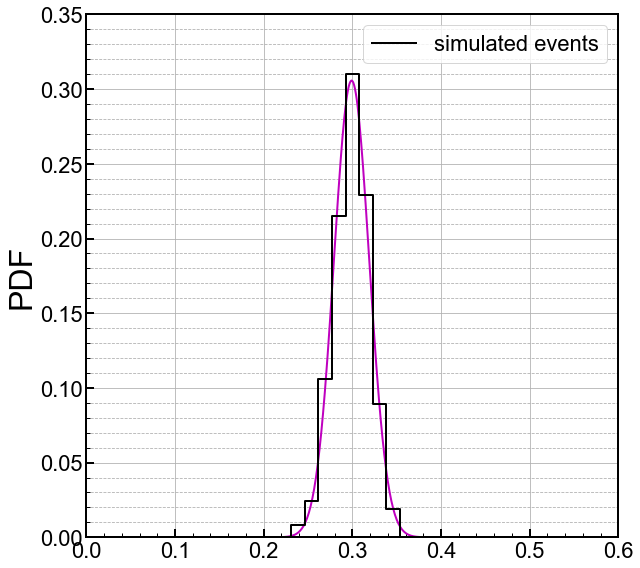

In [6]:
fig,axs = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True,sharey=True)



X = np.arange(0.0,0.6,0.001)
func = lambda x,a,b,c: a*np.exp(-(x-b)**2/(2*c**2))
funcv = np.vectorize(func)

#for i,ax in enumerate(np.ndarray.flatten(axs)):
ax = axs
if True:
    #ax.set_title('markevery=%s' % str(case))
    #ax.plot(x, y, 'o', ls='-', ms=4, markevery=case)
    #ax.text(0.65,0.31,"{:2.1f} keV $\leq$ $E_r$ $<$ {:2.1f} keV".format(erbins[i+1],erbins[i+2]),fontsize=24)
    idx=0
    ax.plot(X,funcv(X,qamps[idx],qmus[idx],qsigs[idx]),color='m',linestyle="-",linewidth=2)
    #ax.plot(X,funcv(X,qamps_ss[i+1],qmus_ss[i+1],qsigs_ss[i+1]),color='m',linestyle="-",linewidth=2)
    #ax.step(xcq_er,qhistos[:,idx]/np.sum(qhistos[:,idx]), where='mid',color='b', linestyle='-', \
    #        label='all scatters', linewidth=2)
    ax.step(xcq,qhistos[:,idx]/np.sum(qhistos[:,idx]), where='mid',color='k', linestyle='-', \
            label='simulated events', linewidth=2)
    ax.set_yscale('linear')
    #ax1.set_yscale('linear')
    ax.set_xlim(0.0, 0.6) 
    ax.set_ylim(0,0.35)
    if(idx>2):
      ax.set_xlabel(r'ionization yield',**axis_font)
    if((idx==0)|(idx==3)):
      ax.set_ylabel('PDF',**axis_font)
    ax.grid(True)
    ax.yaxis.grid(True,which='minor',linestyle='--')
    if(idx==0):
      ax.legend(loc=1,prop={'size':22})
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
 
plt.tight_layout() 
plt.show()

By running the above script several times, it seems that it is **_plausible_** that the true standard deviation is within the estimated standard deviation +/- the uncertainty ascribed by the fit about 68% of the time. 

An example of this for 1000 initial trials is: $\hat{\sigma}$ = 0.0199 $\pm$ 0.00013

This should be checked more systematically, by doing 100 trials and recording the results. 

# 1000 Trials with 10 and 100 Events

Here we do 100 trials of this procedure, using 10 and 100 events as the total number generated.

In [7]:
trials = np.arange(0,1000)
#print(trials)

sig10 = np.zeros(np.shape(trials))
sigerr10 = np.zeros(np.shape(trials))
sig100 = np.zeros(np.shape(trials))
sigerr100 = np.zeros(np.shape(trials))
sig1000 = np.zeros(np.shape(trials))
sigerr1000 = np.zeros(np.shape(trials))

In [8]:
qbins = np.linspace(0,0.4,40)
xcq = (qbins[:-1] + qbins[1:]) / 2

#make 100 trials with NQ=10
for i,bn in enumerate(trials):
  NQ=10
  #NQ = np.random.poisson(NQ)
  Q = np.random.normal(Qmean,Qstd,NQ)
  E = np.ones(np.shape(Q))
  bindf,bindfE = hy.QEr_Ebin(Q,E,[0,2],True)
  qhistos,qerrs = hy.QEr_Qhist(bindf,qbins)
  qamps,qampserrs,qmus,qmuerrs,qsigs,qsigerrs = hy.QEr_Qfit(qhistos,qerrs, qbins,0.1,0.3,0.1,True)
  sig10[i] = np.sqrt(qsigs[0]**2)
  sigerr10[i] = qsigerrs[0]
    
bad10 = np.sum(-qsigerrs[(qsigerrs==-1)&(qampserrs==-1)&(qmuerrs==-1)])/np.shape(trials)[0]
#print(sig10)
#print(sigerr10)

#make 100 trials with NQ=100
for i,bn in enumerate(trials):
  NQ=100
  #NQ = np.random.poisson(NQ)
  Q = np.random.normal(Qmean,Qstd,NQ)
  E = np.ones(np.shape(Q))
  bindf,bindfE = hy.QEr_Ebin(Q,E,[0,2],True)
  qhistos,qerrs = hy.QEr_Qhist(bindf,qbins)
  qamps,qampserrs,qmus,qmuerrs,qsigs,qsigerrs = hy.QEr_Qfit(qhistos,qerrs, qbins,0.1,0.3,0.1,True)
  sig100[i] = np.sqrt(qsigs[0]**2)
  sigerr100[i] = qsigerrs[0]

bad100 = np.sum(-qsigerrs[(qsigerrs==-1)&(qampserrs==-1)&(qmuerrs==-1)])/np.shape(trials)[0]
#print(sig100)
#print(sigerr100)

#make 100 trials with NQ=1000
for i,bn in enumerate(trials):
  NQ=1000
  #NQ = np.random.poisson(NQ)
  Q = np.random.normal(Qmean,Qstd,NQ)
  E = np.ones(np.shape(Q))
  bindf,bindfE = hy.QEr_Ebin(Q,E,[0,2],True)
  qhistos,qerrs = hy.QEr_Qhist(bindf,qbins)
  qamps,qampserrs,qmus,qmuerrs,qsigs,qsigerrs = hy.QEr_Qfit(qhistos,qerrs, qbins,0.1,0.3,0.1,True)
  sig1000[i] = np.sqrt(qsigs[0]**2)
  sigerr1000[i] = qsigerrs[0]

bad1000 = np.sum(-qsigerrs[(qsigerrs==-1)&(qampserrs==-1)&(qmuerrs==-1)])/np.shape(trials)[0]

In [9]:
import nrfano_stats as nfs



truth10,perc10 = nfs.inRange(Qstd,sig10,sigerr10)

#print(truth)
print(bad10*100)
print(perc10*100)

truth100,perc100 = nfs.inRange(Qstd,sig100,sigerr100)

#print(truth)
print(bad100*100)
print(perc100*100)

truth1000,perc1000 = nfs.inRange(Qstd,sig1000,sigerr1000)

#print(truth)
print(bad1000*100)
print(perc1000*100)

0.0
27.200000000000003
0.0
31.0
0.0
35.4


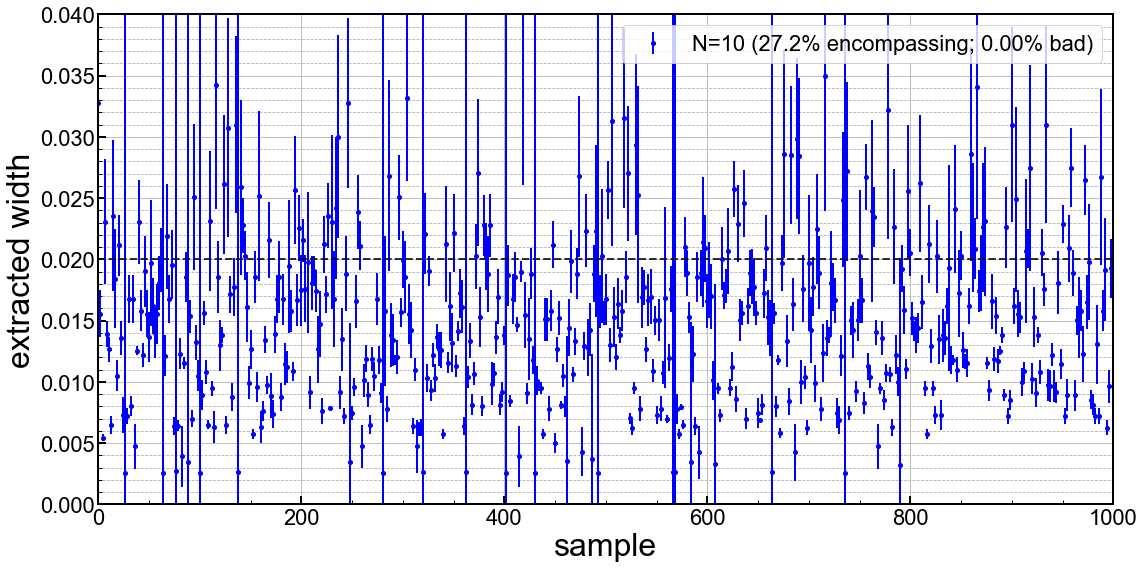

In [10]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(16.0,8.0),sharex=True)
ax1 = axes


cd=2

ax1.errorbar(trials[trials%cd==0],sig10[trials%cd==0], yerr=sigerr10[trials%cd==0],color='b', marker='o', \
         markersize=4,linestyle='none',label='N=10 ({:2.1f}% encompassing; {:2.2f}% bad)'.format(perc10*100,bad10*100),\
             linewidth=2)
#ax1.errorbar(trials,sig100, yerr=sigerr100,color='m', marker='o', \
#         markersize=4,linestyle='none',label='N=100 ({:2.1f}% encompassing)'.format(perc100*100), linewidth=2)


ax1.axhline(Qstd, color='k', linestyle='--', lw=2, alpha=0.8,label=None)


ymin = 0.00
ymax = 0.04



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, np.shape(trials)[0]) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'sample',**axis_font)
ax1.set_ylabel('extracted width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/yield_gauss_fits_10ev.png')
plt.show()

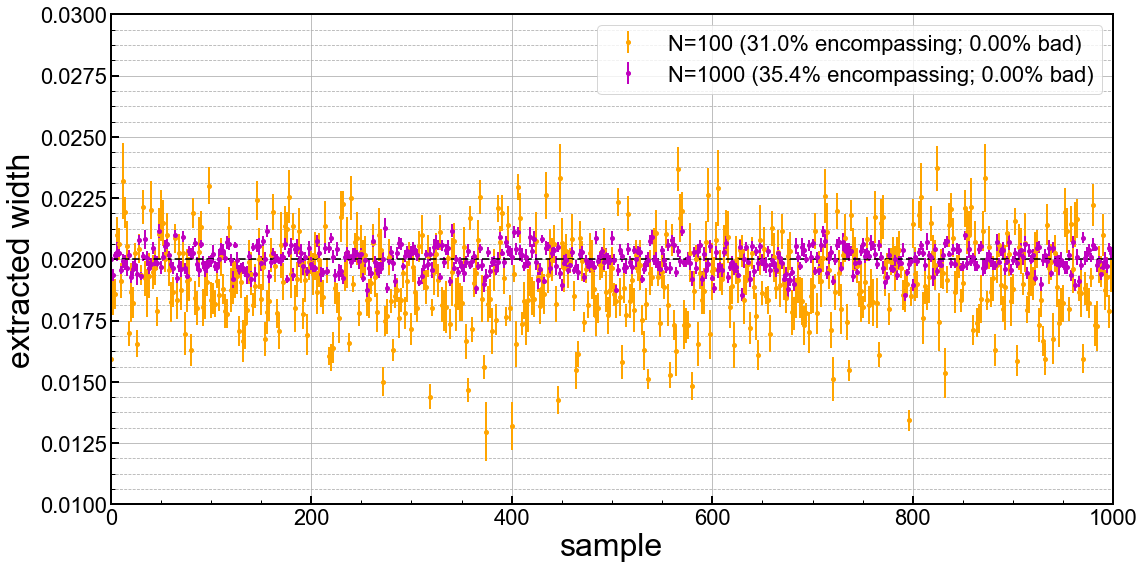

In [11]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(16.0,8.0),sharex=True)
ax1 = axes




ax1.errorbar(trials[trials%cd==0],sig100[trials%cd==0], yerr=sigerr100[trials%cd==0],color='orange', marker='o', \
         markersize=4,linestyle='none',label='N=100 ({:2.1f}% encompassing; {:2.2f}% bad)'.format(perc100*100, \
         bad100*100), linewidth=2)
ax1.errorbar(trials[trials%cd==0],sig1000[trials%cd==0], yerr=sigerr1000[trials%cd==0],color='m', marker='o', \
         markersize=4,linestyle='none',label='N=1000 ({:2.1f}% encompassing; {:2.2f}% bad)'.format(perc1000*100, \
         bad1000*100), linewidth=2)

#using the lines below you can plot ones that fail to overlap the true value or ones that succeed only
#ax1.errorbar(trials[truth100],sig100[truth100], yerr=sigerr100[truth100],color='orange', marker='o', \
#         markersize=4,linestyle='none',label='N=100 ({:2.1f}% encompassing)'.format(perc100*100), linewidth=2)
#ax1.errorbar(trials[truth1000],sig1000[truth1000], yerr=sigerr1000[truth1000],color='m', marker='o', \
#         markersize=4,linestyle='none',label='N=1000 ({:2.1f}% encompassing)'.format(perc1000*100), linewidth=2)
#ax1.errorbar(trials[~truth100],sig100[~truth100], yerr=sigerr100[~truth100],color='orange', marker='o', \
#         markersize=4,linestyle='none',label='N=100 ({:2.1f}% encompassing)'.format(perc100*100), linewidth=2)
#ax1.errorbar(trials[~truth1000],sig1000[~truth1000], yerr=sigerr1000[~truth1000],color='m', marker='o', \
#         markersize=4,linestyle='none',label='N=1000 ({:2.1f}% encompassing)'.format(perc1000*100), linewidth=2)


ax1.axhline(Qstd, color='k', linestyle='--', lw=2, alpha=0.8,label=None)


ymin = 0.01
ymax = 0.03



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, np.shape(trials)[0]) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'sample',**axis_font)
ax1.set_ylabel('extracted width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/yield_gauss_fits_100ev_1000ev.png')
plt.show()

In [12]:
#histogram the results
width_bins = np.linspace(0.0,0.04,100)
n10,nx = np.histogram(sig10,bins=width_bins)
n100,nx = np.histogram(sig100,bins=width_bins)
n1000,nx = np.histogram(sig1000,bins=width_bins)

xc = (nx[:-1] + nx[1:]) / 2
norm = xc[1]-xc[0]

averr10 = np.mean(sigerr10)
averr100 = np.mean(sigerr100)
averr1000 = np.mean(sigerr1000)

#fit the 1000-sample histo to get "true" width

E1000 = np.ones(np.shape(sig1000))
bindf,bindfE = hy.QEr_Ebin(sig1000,E1000,[0,2],True)
qhistos,qerrs = hy.QEr_Qhist(bindf,nx)
print(np.shape(qhistos))
print(np.shape(qerrs))
qamps,qampserrs,qmus,qmuerrs,qsigs,qsigerrs = hy.QEr_Qfit(qhistos,qerrs, nx,100,0.02,0.001)

(99, 1)
(99, 1)
fitting 0
lmfit results
[[Variables]]
    amp:   0.31500278 +/- 0.00324637 (1.03%) (init = 100)
    mean:  0.02000309 +/- 4.2920e-06 (0.02%) (init = 0.02)
    sig:   5.0865e-04 +/- 3.2050e-06 (0.63%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sig) = -0.592
None
[0.00050865]
[3.2050271e-06]


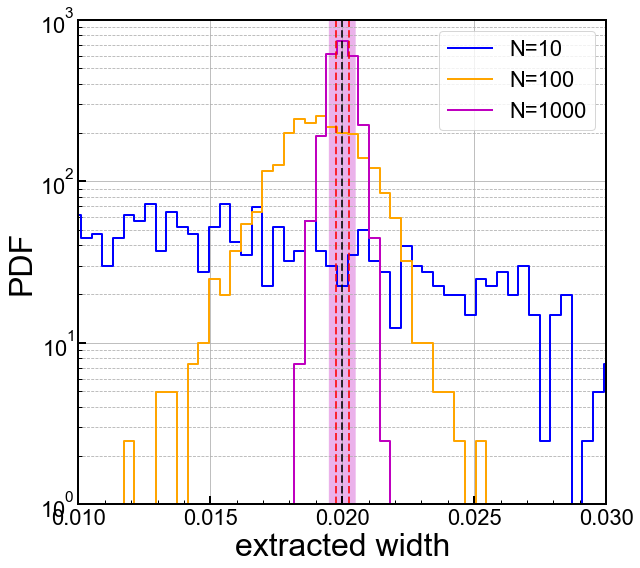

In [13]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



ax1.step(xc,n10/(norm*np.sum(n10)), where='mid',color='b', linestyle='-', \
            label='N=10', linewidth=2)
ax1.step(xc,n100/(norm*np.sum(n100)), where='mid',color='orange', linestyle='-', \
            label='N=100', linewidth=2)
ax1.step(xc,n1000/(norm*np.sum(n1000)), where='mid',color='m', linestyle='-', \
            label='N=1000', linewidth=2)


ax1.axvline(Qstd, color='k', linestyle='--', lw=2, alpha=0.8,label=None)


ymin = 1
ymax = 1000

ax1.axvline(Qstd-averr1000, color='r', linestyle='--', lw=2, alpha=0.8,label=None)
ax1.axvline(Qstd+averr1000, color='r', linestyle='--', lw=2, alpha=0.8,label=None)
erange_x = np.arange(Qstd-qsigs[0], Qstd+qsigs[0], 1e-6)
tshade = ax1.fill_between(erange_x, ymin, ymax, facecolor='m', alpha=0.3)



ax1.set_yscale('log')
#ax1.set_yscale('linear')
ax1.set_xlim(0.01, 0.03) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'extracted width',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/yield_gauss_fits_all.png')
plt.show()

# Dependence on Binning of Fit

For small statistics the fit quality may depend on the binning significantly. Try a smaller binning for the 10-event sub-sample data...

In [14]:
qbins = np.linspace(0.2,0.4,6)
xcq = (qbins[:-1] + qbins[1:]) / 2

NQ=10 
Q = np.random.normal(Qmean,Qstd,NQ)
E = np.ones(np.shape(Q))
bindf,bindfE = hy.QEr_Ebin(Q,E,[0,2],True)
qhistos,qerrs = hy.QEr_Qhist(bindf,qbins)
qamps,qampserrs,qmus,qmuerrs,qsigs,qsigerrs = hy.QEr_Qfit(qhistos,qerrs, qbins,0.1,0.3,0.1,True)

    
bad10 = np.sum(-qsigerrs[(qsigerrs==-1)&(qampserrs==-1)&(qmuerrs==-1)])/np.shape(trials)[0]
print(qhistos)
print(qerrs)
print(qsigs)
print(qsigerrs)

[[0.]
 [1.]
 [5.]
 [4.]
 [0.]]
[[1.29 ]
 [1.75 ]
 [2.805]
 [2.775]
 [1.29 ]]
[0.026919]
[0.00253671]


# Try to Use a Bootstrap Method to Compute Uncertainties

Instead we can use a [bootstrap](https://pypi.org/project/bootstrapped/) method to try to compute the uncertainties of the sample standard deviations and use the sample standard deviations and those uncertainties as our data points. I've `pip` installed the package [`bootstrapped`](https://pypi.org/project/bootstrapped/) to help with this. 

**NOTE: This package has a version of 0.0.2 and I got it after a very cursory internet search. Its development (if it's still being developed) will probably be _volatile_.**

Basically the bootstrap means that you take the sample that you got, and re-sample it many times with replacement. Then calculate the mean and standard deviation of any statistic across those many resamples and use these as the estimator for the corresponding parameter of the parent distribution. 

In [15]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

NQ=10
Q = np.random.normal(Qmean,Qstd,NQ)

print(bs.bootstrap(Q, stat_func=bs_stats.std))

0.021411830320491793    (0.01668026310548551, 0.029750299675544066)


In [16]:
#try the fit of the same sample
#print(qbins)
Q = np.random.normal(Qmean,Qstd,NQ)
#print(Q)
n10,nx = np.histogram(Q,bins=qbins)
E = np.ones(np.shape(Q))
bindf,bindfE = hy.QEr_Ebin(Q,E,[0,2])
qhistos,qerrs = hy.QEr_Qhist(bindf,nx)
print(np.shape(qhistos))
print(np.shape(qerrs))
qamps,qampserrs,qmus,qmuerrs,qsigs,qsigerrs = hy.QEr_Qfit(qhistos,qerrs, nx,1000,0.2,0.5)
print(qampserrs)

energy
(0, 2]    10
dtype: int64
(5, 1)
(5, 1)
fitting 0
lmfit results
[[Variables]]
    amp:   3.78982518 (init = 1000)
    mean:  0.28315949 (init = 0.2)
    sig:   0.00954796 (init = 0.5)
None
bad fit
[0.00954796]
[-1.]
[-1.]
